In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.use_inf_as_na = True
%matplotlib inline
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from collections import Counter
from operator import itemgetter

In [59]:
total_rows = 421099
chunks = 13
chunksize = round(total_rows/chunks)+1

In [61]:
#data was shuffled randomly in excel prior to loading
chunklist = []

for chunk in pd.read_csv('LoanStats3d.csv', chunksize=(chunksize), skipinitialspace=True, header=1):
    chunklist.append(chunk)


# Note the warning about dtypes.

c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


MemoryError: 

In [4]:
for i,chunk in enumerate(chunklist):
    # Convert ID and Interest Rate to numeric.
    #chunk['id'] = pd.to_numeric(chunk['id'], errors='coerce')
    chunk['int_rate'] = pd.to_numeric(chunk['int_rate'].str.strip('%'), errors='coerce')
    # Drop other columns with many unique variables
    #
    print(i,chunk.shape)

0 (32393, 145)
1 (32393, 145)
2 (32393, 145)
3 (32393, 145)
4 (32393, 145)
5 (32393, 145)
6 (32393, 145)
7 (32393, 145)
8 (32393, 145)
9 (32393, 145)
10 (32393, 145)
11 (32393, 145)
12 (32383, 145)


In [5]:
chunklist[-1].tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
421094,NaN,NaN,8000.0,8000.0,8000.0,36 months,12.69,268.36,C,C2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
421095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421097,Total amount funded in policy code 1: 6417608175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421098,Total amount funded in policy code 2: 1944088810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Remove 4 summary rows at the end that don't actually contain data.
chunklist[-1] = chunklist[-1][:-4]

In [7]:
chunklist[-1].tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
421090,NaN,NaN,8400.0,8400.0,8400.0,36 months,6.24,256.46,A,A2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
421091,NaN,NaN,12000.0,12000.0,12000.0,60 months,10.99,260.85,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
421092,NaN,NaN,22875.0,22875.0,22825.0,60 months,20.99,618.72,E,E5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
421093,NaN,NaN,19000.0,19000.0,19000.0,36 months,9.17,605.70,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
421094,NaN,NaN,8000.0,8000.0,8000.0,36 months,12.69,268.36,C,C2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#classifiers are still erroring out
#let's remove some more with large optionsets

categorical = chunklist[0].select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

term
2
grade
7
sub_grade
35
emp_title
14805
emp_length
11
home_ownership
3
verification_status
3
issue_d
12
loan_status
7
pymnt_plan
2
desc
1
purpose
12
title
12
zip_code
854
addr_state
49
earliest_cr_line
576
revol_util
1067
initial_list_status
2
last_pymnt_d
45
next_pymnt_d
2
last_credit_pull_d
46
application_type
2
verification_status_joint
1
hardship_flag
2
hardship_type
1
hardship_reason
9
hardship_status
3
hardship_start_date
18
hardship_end_date
18
payment_plan_start_date
17
hardship_loan_status
4
disbursement_method
1
debt_settlement_flag
2
debt_settlement_flag_date
33
settlement_status
3
settlement_date
35


In [9]:
for chunk in chunklist:
    
    # Drop other columns with many unique variables
    chunk.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
               'sub_grade', 'addr_state', 'desc','debt_settlement_flag_date', 'settlement_date',
                'last_credit_pull_d', 'last_pymnt_d'
               ], 1, inplace=True)

In [10]:

chunklist[1].head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,...,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,settlement_status,settlement_amount,settlement_percentage,settlement_term
32393,NaN,NaN,16800,16800,16800,36 months,14.65,579.51,C,8 years,...,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN
32394,NaN,NaN,7800,7800,7800,36 months,10.64,254.04,B,10+ years,...,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN
32395,NaN,NaN,14000,14000,14000,60 months,13.99,325.69,C,< 1 year,...,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN
32396,NaN,NaN,18000,18000,18000,36 months,9.17,573.83,B,10+ years,...,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN
32397,NaN,NaN,13200,13200,13200,36 months,6.24,403.01,A,4 years,...,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN


In [58]:
newlist=[]
for chunk in chunklist:
    x = chunk.dropna(axis=1,how='any', thresh=25000)
    newlist.append(x)
    print(x.shape)
    print(len(newlist))



(32393, 79)
1
(32393, 79)
2


MemoryError: 

In [12]:
newlist[0].head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,7200,7200,7175,36 months,12.69,241.53,C,< 1 year,OWN,40000.0,...,14.3,0,0,47289,29590,10000,30694,N,Cash,N
1,21000,21000,21000,36 months,14.65,724.38,C,10+ years,MORTGAGE,100000.0,...,12.5,0,0,109154,65977,48700,56454,N,Cash,N
2,30000,30000,30000,36 months,7.26,929.89,A,3 years,RENT,160000.0,...,25.0,0,0,173159,153486,44500,128659,N,Cash,N
3,7000,7000,7000,36 months,13.99,239.21,C,10+ years,RENT,35000.0,...,20.0,0,0,20700,6490,14000,0,N,Cash,N
4,13500,13500,13500,36 months,5.93,410.27,A,NaN,MORTGAGE,42000.0,...,0.0,0,0,154771,36984,56500,27047,N,Cash,N


In [13]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier(n_estimators=10)

In [14]:
for chunk in newlist:
    X = chunk.drop('loan_status', 1)
    Y = chunk['loan_status']
    X = pd.get_dummies(X)
    X = X.dropna(axis=1)
    print(cross_val_score(rfc, X, Y, cv=3).mean())
    

0.979038970126071
0.9788843975819521
0.9780509241310988
0.9780508760609448
0.9789767328378818
0.9787606974029716
0.97845206674046
0.9797177591269118
0.9787298195426221
0.9788842779670824
0.9791621646254868
0.9785138466836459
0.9773000380645537


# DRILL: Third Attempt
So here's your task. Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation.

You'll want to do a few things in this process. First, dive into the data that we have and see which features are most important. This can be the raw features or the generated dummies. You may want to use PCA or correlation matrices.

Can you do it without using anything related to payment amount or outstanding principal? How do you know?

In [15]:
newlist[4].groupby('loan_status')['loan_amnt'].agg('count')

loan_status
Charged Off            5537
Current                5845
Default                  12
Fully Paid            20609
In Grace Period         119
Late (16-30 days)        48
Late (31-120 days)      223
Name: loan_amnt, dtype: int64

In [16]:
#create an ordinal column for correlation approximations

#first create a dict with ranked values for target variable
statusRanks = {
    'Charged Off': 0,
    'Current' : 5,
    'Default' : 1,
    'Fully Paid' : 6,
    'In Grace Period' : 4,
    'Late (16-30 days)': 3,
    'Late (31-120 days)': 2
}

#Map those values to new column
for chunk in newlist:
    chunk['statusCode'] = chunk['loan_status'].map(statusRanks) 

c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [17]:
corr = newlist[0].corr()
corr = pd.DataFrame(corr['statusCode'])

In [18]:
#corr.sort_values(by='statusCode')
corr[abs(corr.statusCode) > .1]

,statusCode
int_rate,-0.274416
dti,-0.112263
total_pymnt,0.310028
total_pymnt_inv,0.310065
total_rec_prncp,0.431751
total_rec_late_fee,-0.112507
recoveries,-0.491131
collection_recovery_fee,-0.488811
last_pymnt_amnt,0.326095
acc_open_past_24mths,-0.121419


In [19]:
#Function to print confusion matrixes
def confusion(Y,y_pred):
    cm = confusion_matrix(Y, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    annot = np.around(cm, 2)
    fig, ax = plt.subplots(figsize=(9,7))
    sns.heatmap(cm, cmap='Blues', annot=annot, lw=0.5)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_aspect('equal')
    plt.show()

In [20]:
rfc = ensemble.RandomForestClassifier(n_estimators=10, class_weight='balanced')

In [21]:
#Fit to the first list and test on the rest:
train = pd.concat(newlist[3:8])
#These columns caused overfitting:
#['int_rate', 'dti', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_late_fee','recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'acc_open_past_24mths', 'num_tl_op_past_12m', 'loan_status']

fitX = train[['int_rate', 'dti', 'total_pymnt','acc_open_past_24mths', 'num_tl_op_past_12m'
                          , 'loan_status']]
fitX = fitX.drop('loan_status', 1)
fitY = train['loan_status']
rfc.fit(fitX, fitY)


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [22]:
for chunk in newlist:
    feats = chunk[['int_rate', 'dti', 'total_pymnt','acc_open_past_24mths', 'num_tl_op_past_12m'
                          , 'loan_status']]
    feats = feats.dropna()
    Y = feats['loan_status']
    feats = feats.drop('loan_status', 1)
    y_pred = rfc.predict(feats)
    print(rfc.score(feats,Y))
    #confusion(Y,y_pred)
    
    

0.6389652085327077
0.6376377612447134
0.6316260689697756
0.9857067885036891
0.9853054672305745
0.9850276294261106
0.9852745963634119
0.9852745963634119
0.6372055691044362
0.6289321767048437
0.6334084524434291
0.6362485722223937
0.6306247876710214


In [23]:
#this is overfitting no matter what I do, and I finally figured out why:
#this prints the depth of each tree in the forest:
[estimator.tree_.max_depth for estimator in rfc.estimators_]

[39, 43, 41, 38, 37, 41, 39, 39, 42, 45]

In [24]:
#I will try limiting to 10 trees
rfc = ensemble.RandomForestClassifier(n_estimators=10, class_weight='balanced', max_depth=10)

#Fit to a subset of the lists and test on the rest:
train = pd.concat(newlist[3:6])
#These columns caused overfitting:
#['int_rate', 'dti', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_late_fee','recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'acc_open_past_24mths', 'num_tl_op_past_12m', 'loan_status']

fitX = train[['int_rate', 'dti', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_late_fee','recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'acc_open_past_24mths', 'num_tl_op_past_12m', 'loan_status']]
fitX = fitX.drop('loan_status', 1)
fitY = train['loan_status']
rfc.fit(fitX, fitY)
[estimator.tree_.max_depth for estimator in rfc.estimators_]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10]

0.7685919797487112


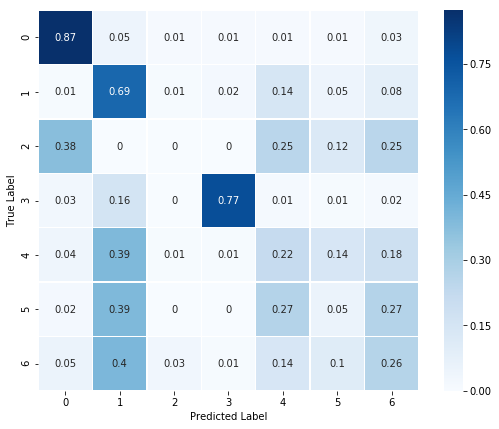

0.7688698175531751


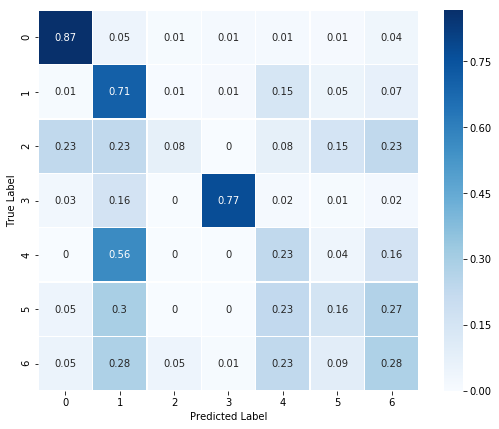

0.7666944521626378


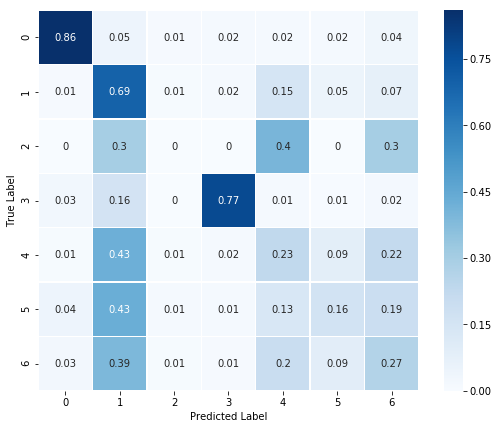

0.7744574445096163


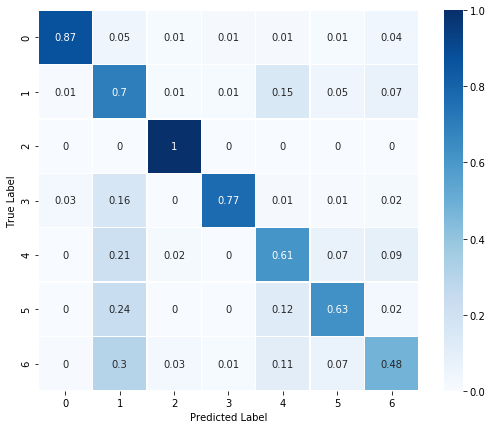

0.7767727595468157


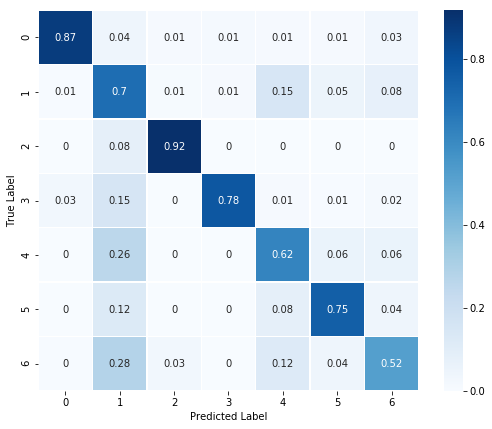

0.775568795727472


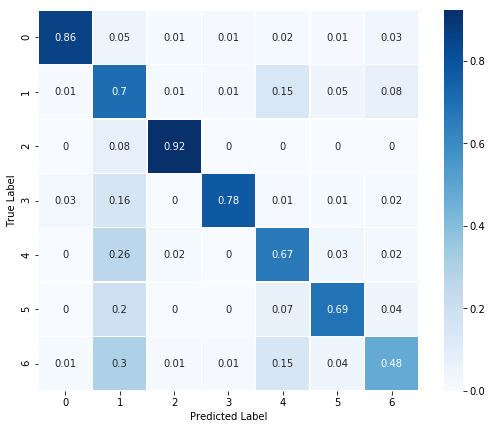

0.7669558237890902


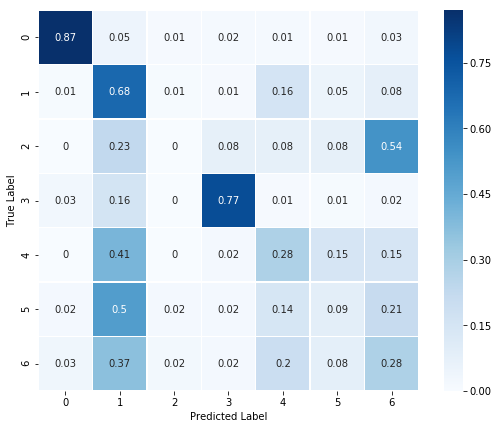

0.7680054332726206


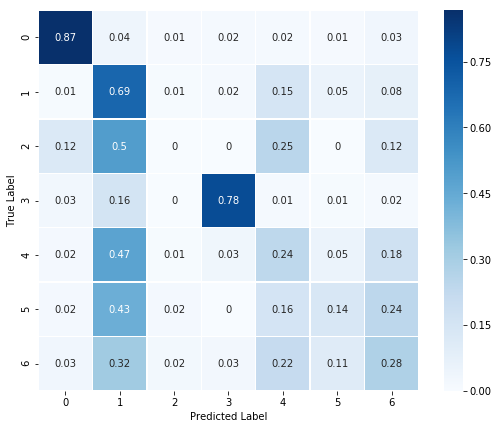

0.766801469453277


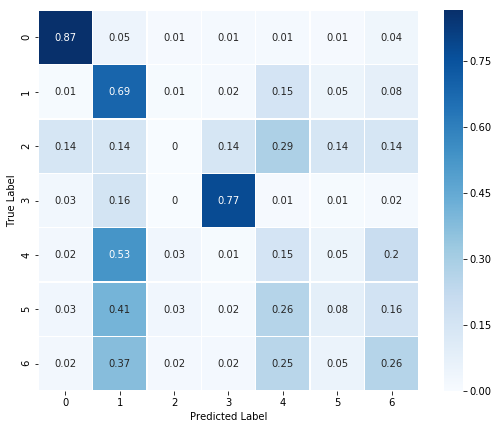

0.7678202080696447


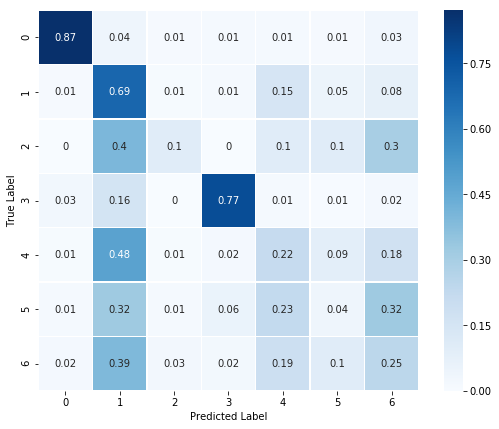

0.7683758836785726


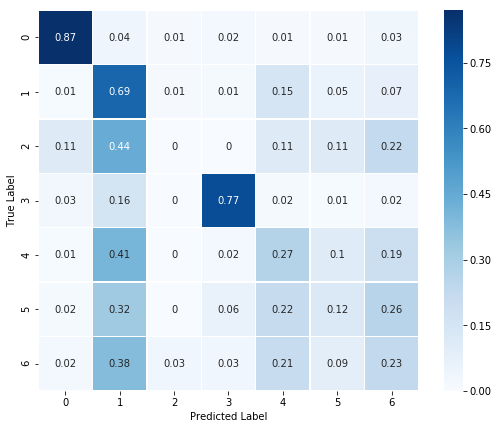

0.7714629703948384


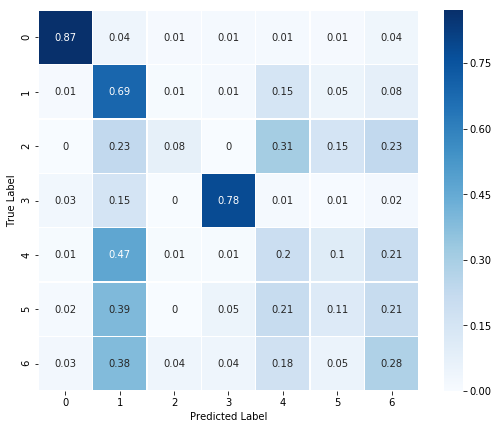

0.7684610395626795


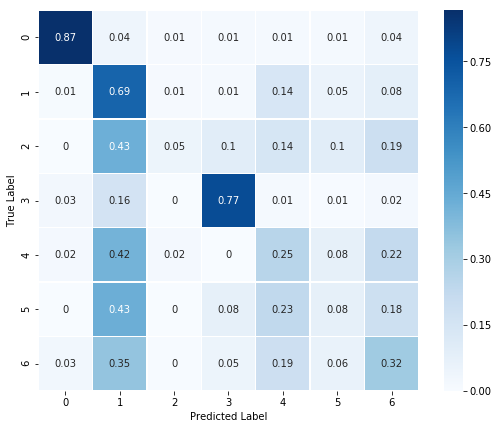

In [25]:
for chunk in newlist:
    feats = chunk[['int_rate', 'dti', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_late_fee','recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'acc_open_past_24mths', 'num_tl_op_past_12m', 'loan_status']]
    feats = feats.dropna()
    Y = feats['loan_status']
    feats = feats.drop('loan_status', 1)
    y_pred = rfc.predict(feats)
    print(rfc.score(feats,Y))
    confusion(Y,y_pred)
    
    

In [26]:
#I've successfully removed overfitting, (performs similarly on all chunks) but the accuracy is now way under 90%.
#I will need to re-expand to the initial set of available attributes.

In [27]:
train.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'pymnt_plan',
       'purpose', 'title', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent

In [28]:
#Fit to a subset of the lists and test on the rest:
train = pd.concat(newlist[3:6])
#These columns are the ones that had correlations:
#['int_rate', 'dti', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_late_fee','recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'acc_open_past_24mths', 'num_tl_op_past_12m', 'loan_status']

fitX = train[['int_rate', 'grade', 'emp_length', 'home_ownership', 'purpose', 'inq_last_6mths',
              'dti', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'avg_cur_bal',
              'total_rec_late_fee','recoveries', 'collection_recovery_fee', 'num_accts_ever_120_pd',
              'last_pymnt_amnt', 'acc_open_past_24mths', 'num_tl_op_past_12m', 'loan_status']]
fitX = fitX.drop('loan_status', 1)
fitX = pd.get_dummies(fitX)
fitY = train['loan_status']
rfc.fit(fitX, fitY)
for chunk in newlist:
    feats = chunk[['int_rate', 'grade', 'emp_length', 'home_ownership', 'purpose', 'inq_last_6mths',
              'dti', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'avg_cur_bal',
              'total_rec_late_fee','recoveries', 'collection_recovery_fee', 'num_accts_ever_120_pd',
              'last_pymnt_amnt', 'acc_open_past_24mths', 'num_tl_op_past_12m', 'loan_status']]
    feats = feats.dropna()
    Y = feats['loan_status']
    feats = feats.drop('loan_status', 1)
    feats = pd.get_dummies(feats)
    y_pred = rfc.predict(feats)
    print(rfc.score(feats,Y))
    #confusion(Y,y_pred)

ValueError: Number of features of the model must match the input. Model n_features is 48 and input n_features is 47 

In [29]:
# The above errors out because if one chunk has a different # of unique values than another, then pd.get_dummies
#will return a different # of columns, which confuses the classifier object. I'll have to try to merge them, though
#I doubt memory can handle that.
features = pd.DataFrame()
for chunk in newlist:
    feats = chunk[['int_rate', 'grade', 'emp_length', 'home_ownership', 'purpose', 'inq_last_6mths',
              'dti', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'avg_cur_bal',
              'total_rec_late_fee','recoveries', 'collection_recovery_fee', 'num_accts_ever_120_pd',
              'last_pymnt_amnt', 'acc_open_past_24mths', 'num_tl_op_past_12m', 'loan_status']]
    features = features.append(feats)
    print(features.shape)

#remove target variable before dummies
Y = features['loan_status']
features = features.drop('loan_status', 1)
features = pd.get_dummies(features)
#replace target variable
features['loan_status'] = Y
features





(32393, 19)
(64786, 19)
(97179, 19)
(129572, 19)
(161965, 19)
(194358, 19)
(226751, 19)
(259144, 19)
(291537, 19)
(323930, 19)
(356323, 19)
(388716, 19)
(421095, 19)


,int_rate,inq_last_6mths,dti,total_pymnt,total_pymnt_inv,total_rec_prncp,avg_cur_bal,total_rec_late_fee,recoveries,collection_recovery_fee,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,loan_status
0,12.69,2.0,10.35,8680.589741,8650.45,7200.00,1480.0,0.0,0.00,0.0000,...,0,0,0,0,1,0,0,0,0,Fully Paid
1,14.65,2.0,14.00,13590.510000,13590.51,8782.64,4713.0,0.0,1245.93,224.2674,...,0,0,0,0,0,0,0,0,0,Charged Off
2,7.26,0.0,13.74,32949.357640,32949.36,30000.00,19186.0,0.0,0.00,0.0000,...,0,0,0,0,0,0,0,0,0,Fully Paid
3,13.99,1.0,5.32,8463.966928,8463.97,7000.00,721.0,0.0,0.00,0.0000,...,0,0,0,0,0,0,0,0,0,Fully Paid
4,5.93,0.0,17.14,14738.969810,14738.97,13500.00,4516.0,0.0,0.00,0.0000,...,0,0,0,0,0,0,0,0,0,Fully Paid
5,14.31,2.0,14.30,24744.671270,24744.67,20000.00,2742.0,0.0,0.00,0.0000,...,0,0,0,0,0,0,0,0,0,Fully Paid
6,9.76,0.0,25.17,17418.030000,17418.03,12241.59,15313.0,0.0,0.00,0.0000,...,0,0,0,0,0,0,0,0,0,Current
7,18.54,2.0,2.19,19875.569890,19875.57,14000.00,23250.0,0.0,0.00,0.0000,...,0,0,0,0,0,0,0,0,0,Fully Paid
8,6.89,0.0,21.12,18859.493570,18859.49,17000.00,23649.0,0.0,0.00,0.0000,...,0,0,0,0,0,0,0,0,0,Fully Paid
9,12.29,0.0,25.16,7230.093607,7230.09,6025.00,11800.0,0.0,0.00,0.0000,...,0,0,0,0,0,0,0,0,0,Fully Paid


In [32]:
rfc = ensemble.RandomForestClassifier(n_estimators=10, class_weight='balanced', max_depth=10)
X = features.drop('loan_status', 1)
Y = features['loan_status']
#print(cross_val_score(rfc, X, Y, cv=10))
rfc.fit(X, Y)
y_pred = rfc.predict(X)
confusion(Y,y_pred)


MemoryError: 

# RESET


In [33]:
#I will have to proceed with half the set. I can't do anything with this many rows. 
#I'm going to use the opportunity to downsample majority classes:
features.groupby('loan_status').agg('count')

,int_rate,inq_last_6mths,dti,total_pymnt,total_pymnt_inv,total_rec_prncp,avg_cur_bal,total_rec_late_fee,recoveries,collection_recovery_fee,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
loan_status,,,,,,,,,,,,,,,,,,,,,
Charged Off,71761,71761,71760,71761,71761,71761,71761,71761,71761,71761,...,71761,71761,71761,71761,71761,71761,71761,71761,71761,71761
Current,74267,74267,74267,74267,74267,74267,74267,74267,74267,74267,...,74267,74267,74267,74267,74267,74267,74267,74267,74267,74267
Default,148,148,148,148,148,148,148,148,148,148,...,148,148,148,148,148,148,148,148,148,148
Fully Paid,269699,269699,269698,269699,269699,269699,269699,269699,269699,269699,...,269699,269699,269699,269699,269699,269699,269699,269699,269699,269699
In Grace Period,1514,1514,1514,1514,1514,1514,1514,1514,1514,1514,...,1514,1514,1514,1514,1514,1514,1514,1514,1514,1514
Late (16-30 days),773,773,773,773,773,773,773,773,773,773,...,773,773,773,773,773,773,773,773,773,773
Late (31-120 days),2933,2933,2933,2933,2933,2933,2933,2933,2933,2933,...,2933,2933,2933,2933,2933,2933,2933,2933,2933,2933


In [109]:
#data was shuffled randomly in excel prior to loading
chunklist = []

for chunk in pd.read_csv('LoanStats3d.csv', chunksize=10027, skipinitialspace=True, header=1):
    chunklist.append(chunk)
len(chunklist)

c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (123,124,125,128,129,130,133) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns 

42

In [110]:
df = pd.DataFrame()
majority = pd.DataFrame()
for raw in chunklist:
    raw.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
               'sub_grade', 'addr_state', 'desc','debt_settlement_flag_date', 'settlement_date',
                'last_credit_pull_d', 'last_pymnt_d', 'id', 'member_id', 'emp_length', 
              'mths_since_last_delinq', 'mths_since_last_record'
               ], 1, inplace=True)
    df = df.append(raw[raw.loan_status == "Default"])
    df = df.append(raw[raw.loan_status == "In Grace Period"])
    df = df.append(raw[raw.loan_status == "Late (16-30 days)"])
    df = df.append(raw[raw.loan_status == "Late (31-120 days)"])
    print("df:",df.shape)
    majority = majority.append(raw[raw.loan_status == "Fully Paid"].sample(n=500))
    majority = majority.append(raw[raw.loan_status == "Current"].sample(n=500))
    majority = majority.append(raw[raw.loan_status == "Charged Off"].sample(n=500))
    print("Majoritydf:", majority.shape)

df: (117, 133)
Majoritydf: (1500, 133)
df: (241, 133)
Majoritydf: (3000, 133)
df: (358, 133)
Majoritydf: (4500, 133)
df: (488, 133)
Majoritydf: (6000, 133)
df: (613, 133)
Majoritydf: (7500, 133)
df: (729, 133)
Majoritydf: (9000, 133)
df: (858, 133)
Majoritydf: (10500, 133)
df: (997, 133)
Majoritydf: (12000, 133)
df: (1121, 133)
Majoritydf: (13500, 133)
df: (1247, 133)
Majoritydf: (15000, 133)
df: (1376, 133)
Majoritydf: (16500, 133)
df: (1509, 133)
Majoritydf: (18000, 133)
df: (1630, 133)
Majoritydf: (19500, 133)
df: (1755, 133)
Majoritydf: (21000, 133)
df: (1883, 133)
Majoritydf: (22500, 133)
df: (2006, 133)
Majoritydf: (24000, 133)
df: (2136, 133)
Majoritydf: (25500, 133)
df: (2268, 133)
Majoritydf: (27000, 133)
df: (2395, 133)
Majoritydf: (28500, 133)
df: (2543, 133)
Majoritydf: (30000, 133)
df: (2664, 133)
Majoritydf: (31500, 133)
df: (2791, 133)
Majoritydf: (33000, 133)
df: (2925, 133)
Majoritydf: (34500, 133)
df: (3038, 133)
Majoritydf: (36000, 133)
df: (3165, 133)
Majoritydf: (3

MemoryError: 

In [121]:
#The above still errored out. I'm going to try to remove columns instead of removing more rows.
#let's get NaN counts with whatever portions of df did get written:
nans = pd.DataFrame(df.isnull().sum(), columns=['nans'])
nans = nans[nans.nans > 100]
nans

,nans
id,5368
member_id,5368
emp_length,271
mths_since_last_delinq,2318
mths_since_last_record,4418
mths_since_last_major_derog,3605
annual_inc_joint,5352
dti_joint,5352
verification_status_joint,5352
open_acc_6m,4946


In [131]:
#now trying again:
df = pd.DataFrame()
majority = pd.DataFrame()
droplist1 =['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc','debt_settlement_flag_date', 'settlement_date',
            'last_credit_pull_d', 'last_pymnt_d', 'id', 'member_id', 'emp_length', 
            'mths_since_last_delinq', 'mths_since_last_record'
            ]

for raw in chunklist:
    for x in droplist1:
        if x in raw.columns:
            raw.drop([x], 1, inplace=True)
            print("accessed droplist")
    for x in nans.index:
        if x in raw.columns:
            raw.drop([x], 1, inplace=True)
            print("accessed nans")
    df = df.append(raw[raw.loan_status == "Default"])
    df = df.append(raw[raw.loan_status == "In Grace Period"])
    df = df.append(raw[raw.loan_status == "Late (16-30 days)"])
    df = df.append(raw[raw.loan_status == "Late (31-120 days)"])
    
    majority = majority.append(raw[raw.loan_status == "Fully Paid"].sample(n=250))
    majority = majority.append(raw[raw.loan_status == "Current"].sample(n=250))
    majority = majority.append(raw[raw.loan_status == "Charged Off"].sample(n=250))
    
print("df:",df.shape)
print("Majoritydf:", majority.shape)

df: (5368, 76)
Majoritydf: (31500, 76)


In [132]:
df = pd.concat([df,majority])
del majority
del chunklist
df.groupby('loan_status').agg('count')

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,home_ownership,annual_inc,verification_status,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
loan_status,,,,,,,,,,,,,,,,,,,,,
Charged Off,10500,10500,10500,10500,10500,10500,10500,10500,10500,10500,...,10366,10500,10500,10500,10500,10500,10500,10500,10500,10500
Current,10500,10500,10500,10500,10500,10500,10500,10500,10500,10500,...,10420,10500,10500,10500,10500,10500,10500,10500,10500,10500
Default,148,148,148,148,148,148,148,148,148,148,...,147,148,148,148,148,148,148,148,148,148
Fully Paid,10500,10500,10500,10500,10500,10500,10500,10500,10500,10500,...,10403,10500,10500,10500,10500,10500,10500,10500,10500,10500
In Grace Period,1514,1514,1514,1514,1514,1514,1514,1514,1514,1514,...,1498,1514,1514,1514,1514,1514,1514,1514,1514,1514
Late (16-30 days),773,773,773,773,773,773,773,773,773,773,...,763,773,773,773,773,773,773,773,773,773
Late (31-120 days),2933,2933,2933,2933,2933,2933,2933,2933,2933,2933,...,2904,2933,2933,2933,2933,2933,2933,2933,2933,2933


In [133]:

df.shape

(36868, 76)

In [134]:
df = df.dropna(axis=1,how='any', thresh=15000)
print(df.shape)
df.head()

(36868, 76)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,home_ownership,annual_inc,verification_status,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
3377,10000.0,10000.0,10000.0,60 months,22.99%,281.85,F,OWN,35000.0,Verified,...,100.0,0.0,0.0,141431.0,12506.0,3000.0,11784.0,N,Cash,N
4585,4000.0,4000.0,4000.0,36 months,12.29%,133.42,C,MORTGAGE,97500.0,Not Verified,...,50.0,0.0,0.0,118846.0,118134.0,5700.0,113146.0,N,Cash,N
5511,3600.0,3600.0,3600.0,36 months,9.17%,114.77,B,MORTGAGE,75000.0,Not Verified,...,0.0,0.0,0.0,402366.0,51613.0,140800.0,40197.0,N,Cash,N
6763,33600.0,33600.0,33600.0,60 months,17.57%,845.38,D,MORTGAGE,110000.0,Verified,...,87.5,0.0,0.0,311154.0,72432.0,23300.0,49572.0,N,Cash,Y
139,12000.0,12000.0,12000.0,36 months,14.65%,413.94,C,RENT,72000.0,Not Verified,...,66.7,0.0,0.0,142953.0,128159.0,35800.0,101253.0,N,Cash,N


In [135]:
#Get dummies for categorical variables, but remove the target first
dum = df.drop('loan_status',1)
dum = pd.get_dummies(dum)
dum['loan_status'] = df['loan_status']
print(dum.shape)
dum = dum.dropna()
print(dum.shape)
dum.head()

(36868, 237)
(36480, 237)


,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,...,next_pymnt_d_Oct-18,next_pymnt_d_Sep-18,application_type_Individual,application_type_Joint App,hardship_flag_N,hardship_flag_Y,disbursement_method_Cash,debt_settlement_flag_N,debt_settlement_flag_Y,loan_status
3377,10000.0,10000.0,10000.0,281.85,35000.0,12.86,0.0,2.0,5.0,0.0,...,0,0,1,0,1,0,1,1,0,Default
4585,4000.0,4000.0,4000.0,133.42,97500.0,14.41,0.0,1.0,10.0,0.0,...,0,0,1,0,1,0,1,1,0,Default
5511,3600.0,3600.0,3600.0,114.77,75000.0,30.30,0.0,1.0,31.0,0.0,...,0,0,1,0,1,0,1,1,0,Default
6763,33600.0,33600.0,33600.0,845.38,110000.0,24.05,0.0,0.0,20.0,0.0,...,0,0,1,0,1,0,1,0,1,Default
139,12000.0,12000.0,12000.0,413.94,72000.0,28.10,1.0,1.0,11.0,0.0,...,0,0,1,0,1,0,1,1,0,In Grace Period


In [137]:
rfc = ensemble.RandomForestClassifier(n_estimators=10, class_weight='balanced', max_depth=10)
X = dum.drop('loan_status', 1)
Y = dum['loan_status']
print(cross_val_score(rfc, X, Y, cv=10))
rfc.fit(X, Y)
y_pred = rfc.predict(X)
confusion(Y,y_pred)

c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_validation.py:542: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


MemoryError: 

In [94]:
#Now I'll start with the dummies df and see if I can reduce the attributes but stay over 90% accuracy.

In [95]:
#create an ordinal column for correlation approximations

#first create a dict with ranked values for target variable
statusRanks = {
    'Charged Off': 0,
    'Current' : 5,
    'Default' : 1,
    'Fully Paid' : 6,
    'In Grace Period' : 4,
    'Late (16-30 days)': 3,
    'Late (31-120 days)': 2
}

#Map those values to new column
dum['statusCode'] = dum['loan_status'].map(statusRanks) 

In [96]:
corr = dum.corr()
corr = pd.DataFrame(corr['statusCode'])

In [100]:
corr = corr.sort_values(by='statusCode')
corr[abs(corr.statusCode) > .25]

,statusCode
loan_status_Charged Off,-0.854467
recoveries,-0.418046
collection_recovery_fee,-0.416351
debt_settlement_flag_Y,-0.274360
debt_settlement_flag_N,0.274360
total_pymnt,0.359965
total_pymnt_inv,0.360065
last_pymnt_amnt,0.369411
loan_status_Current,0.385519
total_rec_prncp,0.495419


# Go even smaller

In [138]:
#data was shuffled randomly in excel prior to loading
chunklist = []

for chunk in pd.read_csv('LoanStats3d.csv', chunksize=10027, skipinitialspace=True, header=1):
    chunklist.append(chunk)
len(chunklist)

c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (123,124,125,128,129,130,133) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns 

42

In [110]:
df = pd.DataFrame()
majority = pd.DataFrame()
for raw in chunklist:
    raw.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
               'sub_grade', 'addr_state', 'desc','debt_settlement_flag_date', 'settlement_date',
                'last_credit_pull_d', 'last_pymnt_d', 'id', 'member_id', 'emp_length', 
              'mths_since_last_delinq', 'mths_since_last_record'
               ], 1, inplace=True)
    df = df.append(raw[raw.loan_status == "Default"])
    df = df.append(raw[raw.loan_status == "In Grace Period"])
    df = df.append(raw[raw.loan_status == "Late (16-30 days)"])
    df = df.append(raw[raw.loan_status == "Late (31-120 days)"])
    print("df:",df.shape)
    majority = majority.append(raw[raw.loan_status == "Fully Paid"].sample(n=150))
    majority = majority.append(raw[raw.loan_status == "Current"].sample(n=150))
    majority = majority.append(raw[raw.loan_status == "Charged Off"].sample(n=150))
    print("Majoritydf:", majority.shape)

df: (117, 133)
Majoritydf: (1500, 133)
df: (241, 133)
Majoritydf: (3000, 133)
df: (358, 133)
Majoritydf: (4500, 133)
df: (488, 133)
Majoritydf: (6000, 133)
df: (613, 133)
Majoritydf: (7500, 133)
df: (729, 133)
Majoritydf: (9000, 133)
df: (858, 133)
Majoritydf: (10500, 133)
df: (997, 133)
Majoritydf: (12000, 133)
df: (1121, 133)
Majoritydf: (13500, 133)
df: (1247, 133)
Majoritydf: (15000, 133)
df: (1376, 133)
Majoritydf: (16500, 133)
df: (1509, 133)
Majoritydf: (18000, 133)
df: (1630, 133)
Majoritydf: (19500, 133)
df: (1755, 133)
Majoritydf: (21000, 133)
df: (1883, 133)
Majoritydf: (22500, 133)
df: (2006, 133)
Majoritydf: (24000, 133)
df: (2136, 133)
Majoritydf: (25500, 133)
df: (2268, 133)
Majoritydf: (27000, 133)
df: (2395, 133)
Majoritydf: (28500, 133)
df: (2543, 133)
Majoritydf: (30000, 133)
df: (2664, 133)
Majoritydf: (31500, 133)
df: (2791, 133)
Majoritydf: (33000, 133)
df: (2925, 133)
Majoritydf: (34500, 133)
df: (3038, 133)
Majoritydf: (36000, 133)
df: (3165, 133)
Majoritydf: (3

MemoryError: 

In [139]:
#The above still errored out. I'm going to try to remove columns instead of removing more rows.
#let's get NaN counts with whatever portions of df did get written:
nans = pd.DataFrame(df.isnull().sum(), columns=['nans'])
nans = nans[nans.nans > 100]
nans

,nans
next_pymnt_d,21000
bc_open_to_buy,342
bc_util,363
mths_since_recent_bc,331
percent_bc_gt_75,367


In [141]:
#now trying again:
df = pd.DataFrame()
majority = pd.DataFrame()
droplist1 =['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc','debt_settlement_flag_date', 'settlement_date',
            'last_credit_pull_d', 'last_pymnt_d', 'id', 'member_id', 'emp_length', 
            'mths_since_last_delinq', 'mths_since_last_record'
            ]

for raw in chunklist:
    for x in droplist1:
        if x in raw.columns:
            raw.drop([x], 1, inplace=True)
            #print("accessed droplist")
    for x in nans.index:
        if x in raw.columns:
            raw.drop([x], 1, inplace=True)
            #print("accessed nans")
    df = df.append(raw[raw.loan_status == "Default"])
    df = df.append(raw[raw.loan_status == "In Grace Period"])
    df = df.append(raw[raw.loan_status == "Late (16-30 days)"])
    df = df.append(raw[raw.loan_status == "Late (31-120 days)"])
    
    majority = majority.append(raw[raw.loan_status == "Fully Paid"].sample(n=250))
    majority = majority.append(raw[raw.loan_status == "Current"].sample(n=250))
    majority = majority.append(raw[raw.loan_status == "Charged Off"].sample(n=250))
    
print("df:",df.shape)
print("Majoritydf:", majority.shape)

df: (5368, 123)
Majoritydf: (31500, 123)


In [142]:
df = pd.concat([df,majority])
del majority
del chunklist
df.groupby('loan_status').agg('count')

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,home_ownership,annual_inc,verification_status,...,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,settlement_status,settlement_amount,settlement_percentage,settlement_term
loan_status,,,,,,,,,,,,,,,,,,,,,
Charged Off,10500,10500,10500,10500,10500,10500,10500,10500,10500,10500,...,114,72,114,114,10500,10500,1498,1498,1498,1498
Current,10500,10500,10500,10500,10500,10500,10500,10500,10500,10500,...,91,86,91,91,10500,10500,0,0,0,0
Default,148,148,148,148,148,148,148,148,148,148,...,11,11,11,11,148,148,17,17,17,17
Fully Paid,10500,10500,10500,10500,10500,10500,10500,10500,10500,10500,...,17,14,17,17,10500,10500,0,0,0,0
In Grace Period,1514,1514,1514,1514,1514,1514,1514,1514,1514,1514,...,90,86,90,90,1514,1514,0,0,0,0
Late (16-30 days),773,773,773,773,773,773,773,773,773,773,...,98,94,98,98,773,773,0,0,0,0
Late (31-120 days),2933,2933,2933,2933,2933,2933,2933,2933,2933,2933,...,302,272,302,302,2933,2933,227,227,227,227


In [143]:

df.shape

(36868, 123)

In [144]:
df = df.dropna(axis=1,how='any', thresh=15000)
print(df.shape)
df.head()

(36868, 74)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,home_ownership,annual_inc,verification_status,...,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
3377,10000.0,10000.0,10000.0,60 months,22.99%,281.85,F,OWN,35000.0,Verified,...,81.2,0.0,0.0,141431.0,12506.0,3000.0,11784.0,N,Cash,N
4585,4000.0,4000.0,4000.0,36 months,12.29%,133.42,C,MORTGAGE,97500.0,Not Verified,...,61.5,0.0,0.0,118846.0,118134.0,5700.0,113146.0,N,Cash,N
5511,3600.0,3600.0,3600.0,36 months,9.17%,114.77,B,MORTGAGE,75000.0,Not Verified,...,100.0,0.0,0.0,402366.0,51613.0,140800.0,40197.0,N,Cash,N
6763,33600.0,33600.0,33600.0,60 months,17.57%,845.38,D,MORTGAGE,110000.0,Verified,...,96.3,0.0,0.0,311154.0,72432.0,23300.0,49572.0,N,Cash,Y
139,12000.0,12000.0,12000.0,36 months,14.65%,413.94,C,RENT,72000.0,Not Verified,...,62.5,0.0,0.0,142953.0,128159.0,35800.0,101253.0,N,Cash,N


In [145]:
#Get dummies for categorical variables, but remove the target first
dum = df.drop('loan_status',1)
dum = pd.get_dummies(dum)
dum['loan_status'] = df['loan_status']
print(dum.shape)
dum = dum.dropna()
print(dum.shape)
dum.head()

(36868, 232)
(30656, 232)


,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,...,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App,hardship_flag_N,hardship_flag_Y,disbursement_method_Cash,debt_settlement_flag_N,debt_settlement_flag_Y,loan_status
3377,10000.0,10000.0,10000.0,281.85,35000.0,12.86,0.0,2.0,5.0,0.0,...,1,0,1,0,1,0,1,1,0,Default
4585,4000.0,4000.0,4000.0,133.42,97500.0,14.41,0.0,1.0,10.0,0.0,...,1,0,1,0,1,0,1,1,0,Default
5511,3600.0,3600.0,3600.0,114.77,75000.0,30.30,0.0,1.0,31.0,0.0,...,1,0,1,0,1,0,1,1,0,Default
6763,33600.0,33600.0,33600.0,845.38,110000.0,24.05,0.0,0.0,20.0,0.0,...,0,1,1,0,1,0,1,0,1,Default
139,12000.0,12000.0,12000.0,413.94,72000.0,28.10,1.0,1.0,11.0,0.0,...,0,1,1,0,1,0,1,1,0,In Grace Period


[0.85826002 0.86249593 0.85462842 0.84452412 0.85621128 0.85383361
 0.85770235 0.86283475 0.85499673 0.85793599]


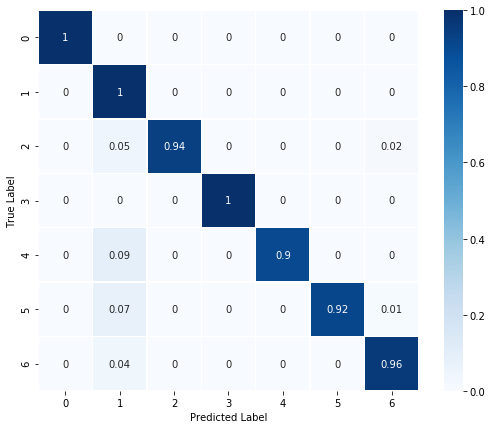

In [147]:
rfc = ensemble.RandomForestClassifier(n_estimators=10)
X = dum.drop('loan_status', 1)
Y = dum['loan_status']
print(cross_val_score(rfc, X, Y, cv=10))
rfc.fit(X, Y)
y_pred = rfc.predict(X)
confusion(Y,y_pred)